In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.25)
import sspals

In [3]:
from mc_sspals import initialize, annihilate, convert
from mc_sspals.tools import tbin, zbin, spectrum
from mc_sspals.laser import Laser, Transition, frac_excite, rydberg
from mc_sspals.chamber import Grid, Chamber, collide
from mc_sspals.plots import bksub

In [4]:
# positrons
num = int(1e6)
sigma_x = 1e-3
sigma_t = 2e-9
# converter
eff = 0.25
T = 400
# Lyman-alpha
lyman_alpha = Transition(wavelength=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))
threshold = 0.002
uv = Laser(energy=0.001, wavelength=2.43e-7, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=15e-9, sigma_t=3e-9)
ryd_life = 4e-6
# physical
grid = Grid(0.009, max_radius=0.01, open_area=0.9)
chamber = Chamber(radius=0.018, distance=0.03)
efield = Grid(0.009, open_area=0.0)
# detector
kappa = 9e-9

In [5]:
df = initialize(num, sigma_t=sigma_t, sigma_x=sigma_x)
df = convert(df, eff=eff, T=T)
dr = rydberg(df, uv, lyman_alpha, threshold, ryd_life, prob=0.5)
dr.groupby('status').count()

,lifetime,ti,xi,yi,zi,vx,vy,vz
status,,,,,,,,
Rydberg,33484,33484,33484,33484,33484,33484,33484,33484
e+,750072,750072,750072,750072,750072,0,0,0
o-Ps,216444,216444,216444,216444,216444,216444,216444,216444


In [6]:
rydbergs = dr[dr.status == 'Rydberg'].index
di = dr.copy()
di.loc[rydbergs] = collide(di.loc[rydbergs], efield, status='ionized')

In [7]:
da = annihilate(collide(dr, grid, chamber))
death = np.unique(da.status) # how many ways to die?
death

array(['Rydberg', 'e+', 'grid', 'o-Ps', 'wall'], dtype=object)

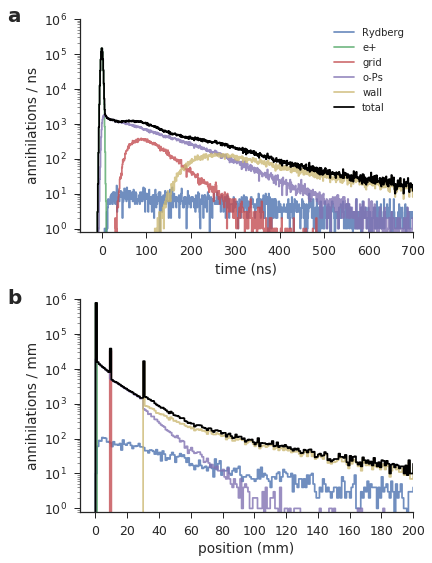

In [8]:
## plotting ##
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharey=True)

## lifetime ##
# components
for d in death:
    x1, y1 = tbin(da[da['status'] == d])
    ax[0].step(x1*1e9, y1, where='mid', label=d, alpha=0.8)
# total
x1, y1 = tbin(da)
# format
ax[0].step(x1*1e9, y1, where='mid', c='k', label='total')
ax[0].set_yscale('log')
ax[0].set_xlim(-50, 700)
ax[0].set_ylabel("annihilations / ns")
ax[0].set_xlabel("time (ns)")

## position ##
# components
for d in death:
    x2, y2 = zbin(da[da['status'] == d])
    ax[1].step(x2*1e3, y2, where='mid', label=d, alpha=0.8)

# total
x2, y2 = zbin(da)
# format
ax[1].set_ylabel("annihilations / mm")
ax[1].set_xlabel("position (mm)")
ax[1].step(x2*1e3, y2, where='mid', c='k', label='total')
ax[1].set_xlim(-10, 200)
ax[1].set_ylim(.8, 1e6)
ax[1].set_yscale('log')
ax[1].set_xticks([0, 20, 40, 60, 80, 100, 120 ,140, 160, 180, 200])
sns.despine()

# labels
fig.text(-0.005, 0.955, "a", fontsize=20, fontweight='bold')
fig.text(-0.005, 0.465, "b", fontsize=20, fontweight='bold')
ax[0].legend(loc=0, fontsize=10)

#output
plt.tight_layout()
plt.savefig("../images/mc_ryd_parts.pdf", dpi=200, bbox_inches='tight')
plt.show()

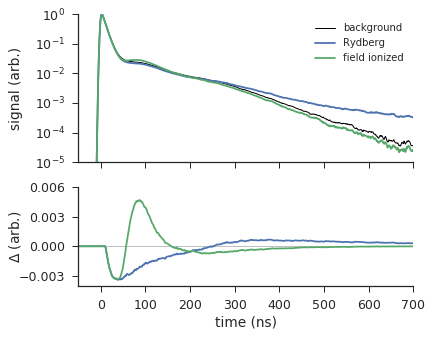

In [9]:
fig, ax = bksub()

dt=1e-9
bk = annihilate(collide(df, grid, chamber))
ryd = annihilate(collide(dr, grid, chamber))
ion = annihilate(collide(di, grid, chamber))

# MC
xvals, yvals = spectrum(bk, amp=1.0, dt=dt, kappa=kappa)
ax[0].plot(xvals * 1e9, yvals, c='k', lw=1, label='background')

xvals2, yvals2 = spectrum(ryd, amp=1.0, dt=dt, kappa=kappa)
ax[0].plot(xvals2 * 1e9, yvals2, label='Rydberg')
ax[1].plot(xvals2 * 1e9, yvals2 - yvals, label='Rydberg')

xvals3, yvals3 = spectrum(ion, amp=1.0, dt=dt, kappa=kappa)
ax[0].plot(xvals3* 1e9, yvals3, label='field ionized')
ax[1].plot(xvals3* 1e9, yvals3 - yvals, label='field ionized')

ax[0].legend(loc=0, fontsize=10)
sns.despine(ax=ax[0], trim=False)
sns.despine(ax=ax[1], trim=False)

#output
plt.savefig("../images/mc_rydberg.pdf", bbox_inches='tight', dpi=200)
plt.show()

In [10]:
frac_excite(df, uv, lyman_alpha, threshold, prob=0.5)

0.13946176325286577

In [11]:
limits = [-1.0E-8, 3.5e-8, 7e-7]
fr = sspals.sspals_1d(spectrum(ryd, amp=1.0, dt=dt, kappa=kappa)[1], dt, limits=limits)[-1]
print(fr)
fi = sspals.sspals_1d(spectrum(ion, amp=1.0, dt=dt, kappa=kappa)[1], dt, limits=limits)[-1]
print(fi)
fb = sspals.sspals_1d(spectrum(bk, amp=1.0, dt=dt, kappa=kappa)[1], dt, limits=limits)[-1]
print(fb)
Sr = sspals.signal(fr, 0, fb, 0)[0]
print(Sr)
Si = sspals.signal(fi, 0, fb, 0)[0]
print(Si)

0.2244235219528741
0.23096295141366305
0.2280557726492679
1.5927028087028199
-1.2747665760104026


In [12]:
limits = [-1.0E-8, 2.5e-7, 7e-7]
fr = sspals.sspals_1d(spectrum(ryd, amp=1.0, dt=dt, kappa=kappa)[1], dt, limits=limits)[-1]
print(fr)
fi = sspals.sspals_1d(spectrum(ion, amp=1.0, dt=dt, kappa=kappa)[1], dt, limits=limits)[-1]
print(fi)
fb = sspals.sspals_1d(spectrum(bk, amp=1.0, dt=dt, kappa=kappa)[1], dt, limits=limits)[-1]
print(fb)
Sr = sspals.signal(fr, 0, fb, 0)[0]
print(Sr)
Si = sspals.signal(fi, 0, fb, 0)[0]
print(Si)

0.04151293662221052
0.025045336056876005
0.02982431703358916
-39.19157503408122
16.023773390454853
